# Text classification analysis
In this notebook, we are going to explore text clustering using conventional techniques in Natural Language Processing (NLP).  
The following methods will be discussed and analyzed in a small and straightforward dataset with 38 documents.  
1. Using TF-IDF and K-means for clustering
2. Using Doc2Vec and K-means for clustering
3. Using LDA for topic modeling and K-means for clustering
4. Training a word2vec from scratch and using K-means for clustering
5. Using pre-trained fast text embedding model for sentence embedding and K-means for clustering
6. Using BERT for extracting encoding features from texts and K-means for clustering
 
## Structure of the notebook
This notebook includes three parts.  
The first part imports and defines useful libraries and methods that will be used in the future and of course, loading the data.  
The second part demonstrates the methods as mentioned above for clustering text including their advantages and disadvantages.  
The third and final parts conclude the above methods.

# Importing necessary modules and define the initial works



## importing necessary modules

In [0]:
import string
import re
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
! pip install spacy >/dev/null
! python -m spacy download en >/dev/null
import spacy
spacy.load("en")
from spacy.lang.en import English

  

## Defining some utility functions

In [0]:
# utility function
parser=English()
rand_state=22
nb_clusters = 8
def clean_text_to_tokens(text):
  """
  clean the text in a way that removes stop words and returns lemmatized words 
  """
  doc=parser(text.lower())
  tokenized_words=[]
  for word in doc:
    if not word.is_stop and not word.is_punct and word.is_alpha:
      tokenized_words.append(word.lemma_)
  return tokenized_words

def get_kmeans_clustering(feature_matrix):
  """
  Given matrix of features [N,d] this function perform the Kmeans clustering to the data.
  where N is number of data and d is dimension of features
  """
  kmeans = KMeans(n_clusters=nb_clusters,random_state=rand_state)
  kmeans.fit(feature_matrix)
  clusters = kmeans.labels_.tolist()
  order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
  return clusters, order_centroids

def visualize_clusters(feature_matrix, clusters, cluster_titles):
  """
  visualize clusters based on their cluster name (top 5 most frequent words in that cluster)
  and title of documents that fitted in the cluster in a 2-dimensional figure
  """
  # two components as we're plotting points in a two-dimensional plane
  # "precomputed" because we provide a distance matrix
  # we will also specify `random_state` so the plot is reproducible.
  mds = MDS(n_components=2, dissimilarity="precomputed", random_state=rand_state)
  dist = 1 - cosine_similarity(feature_matrix)
  pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

  xs, ys = pos[:, 0], pos[:, 1]
  #set up colors per clusters using a dict.  number of colors must correspond to K
  cluster_colors = ['black','grey', 'blue', 'rosybrown', 'firebrick', 'red', 'darksalmon', 'sienna']
  #create data frame that has the result of the MDS plus the cluster numbers and titles
  mds_df = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 

  fig, ax = plt.subplots(figsize=(20, 16)) # set size
  ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
  groups = mds_df.groupby('label')
  for name, group in groups:
      ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
              label=cluster_titles[name], color=cluster_colors[name], 
              mec='none')
      ax.set_aspect('auto')
      ax.tick_params(\
          axis= 'x',          # changes apply to the x-axis
          which='both',      # both major and minor ticks are affected
          bottom=False,      # ticks along the bottom edge are off
          top=False,         # ticks along the top edge are off
          labelbottom=True)
      ax.tick_params(\
          axis= 'y',         # changes apply to the y-axis
          which='both',      # both major and minor ticks are affected
          left=False,      # ticks along the bottom edge are off
          top=False,         # ticks along the top edge are off
          labelleft=True)

  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

  #add label in x,y position with the title of each document
  for i in range(len(mds_df)):
      ax.text(mds_df.iloc[i]['x'], mds_df.iloc[i]['y'], titles[i], size=8)  



## Reading data

In [3]:
# reading data
data_df = pd.read_csv("Class Corpus.csv")
texts = data_df['Text'].values.tolist()
titles = data_df['DSI_Title'].values.tolist()
print("We have %d data"%len(texts))

We have 38 data


# Clustering works

## First part using tradional methods

### Clustering using tf-idf
The following cell demonstrates using [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) for extracting meaningful features and cluster them into 8 clusters.

top 5 most frequent words in 8 clusters
Cluster 0 frequent words: trade, tariff, america, economy, market
Cluster 1 frequent words: kavanaugh, senate, vote, senator, judge
Cluster 2 frequent words: plan, term, people, rule, administration
Cluster 3 frequent words: deal, trade, mexico, agreement, unite state
Cluster 4 frequent words: election, foreign, deny, statement, washington
Cluster 5 frequent words: administration, nation, unite, official, trump administration
Cluster 6 frequent words: order, court, wednesday, think, law
Cluster 7 frequent words: base, time, leader, ask, white house


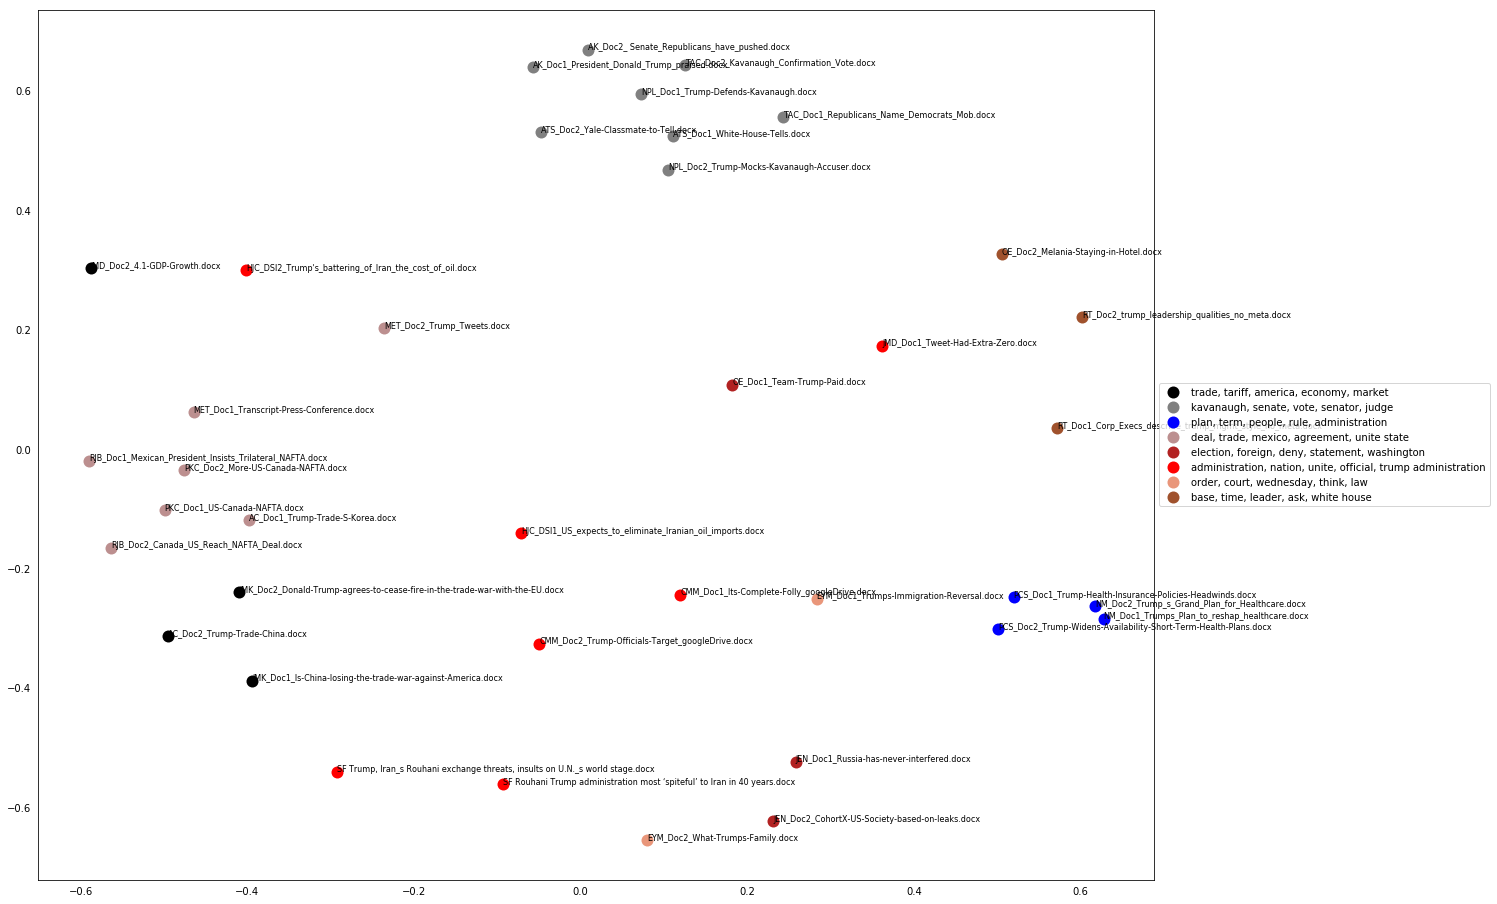

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
np.random.seed(rand_state)
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=clean_text_to_tokens, ngram_range=(1,3))
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)
terms = tfidf_vectorizer.get_feature_names()

clusters, order_centroids = get_kmeans_clustering(tfidf_matrix)
nb_topics=5
print("top {} most frequent words in {} clusters".format(nb_topics, nb_clusters))
cluster_titles=[]
for i in range(nb_clusters):
  words=', '.join([terms[order_centroids[i][j]] for j in range(nb_topics)])
  cluster_titles.append(words)
  print("Cluster {} frequent words: {}".format(i, words))
  
visualize_clusters(tfidf_matrix, clusters, cluster_titles)


## Discussion on tf-idf results
As we can see from visualized clusters, these documents are spread good enough in 2-d dimensions.  
Because tf-idf uses term-frequency within documents, and the number documents are sufficiently small this method yields to a pretty good result.   
Because this method uses just non-stop words for clustering and feature extraction, this property could be a disadvantage for some documents. Because it does not use the relationship between words together. Therefore, the features that we are using for clustering is just good enough for that measure, and for more complicated documents, where the connection and negation existed between words matters, this method would not yield to a good result.

### Clustering using LDA
The following cell demonstrates clustering texts using [Latent Dirichlet Allocation](http://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) (LDA)  
LDA is a probabilistic topic model that assumes documents are a mixture of topics and that each word in the document is attributable to the document's topics. 

In [5]:
! pip install gensim > /dev/null
import gensim
from gensim import corpora
tokenized_text = [clean_text_to_tokens(text) for text in texts]
dictionary = corpora.Dictionary(tokenized_text)
corpus = [dictionary.doc2bow(text) for text in tokenized_text]
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = nb_clusters, id2word=dictionary, passes=15, random_state=rand_state)
topics = ldamodel.show_topics(formatted=False,num_words=nb_topics)
print("top {} most frequent words in {} clusters".format(nb_topics, nb_clusters))
cluster_titles=[]
for i in range(nb_clusters):
  words = ', '.join([p[0] for p in  topics[i][1]])
  cluster_titles.append(words)
  print("Cluster {} frequent words: {}".format(i, words))
  


top 5 most frequent words in 8 clusters
Cluster 0 frequent words: south, korea, deal, trade, trump
Cluster 1 frequent words: deal, trade, mexico, unite, say
Cluster 2 frequent words: family, order, trump, mob, say
Cluster 3 frequent words: say, canada, deal, trump, agreement
Cluster 4 frequent words: plan, term, short, insurance, trump
Cluster 5 frequent words: iran, trump, oil, say, price
Cluster 6 frequent words: trump, kavanaugh, senate, say, vote
Cluster 7 frequent words: trump, trade, china, president, mr


## Discussion on LDA results
LDA is just another method that uses term frequency and verifies the fidelity of our previous result with tf-idf.  
As we can see the term frequencies that extracted in the cluster are very similar to tf-idf


## Second part: using machine learning (NLP) methods

### Using Doc2Vec
Document to Vector learns paragraph and document embeddings via the distributed memory and distributed bag of words models using this [paper](https://arxiv.org/pdf/1405.4053v2.pdf).  


top 5 most frequent words in 8 clusters
Cluster 0 frequent words: south, korea, trade, deal, trump
Cluster 1 frequent words: china, trade, war, state, trump
Cluster 2 frequent words: trump, kavanaugh, vote, say, testimony
Cluster 3 frequent words: kavanaugh, nomination, senator, senate, confirmation
Cluster 4 frequent words: investigation, kavanaugh, say, judge, senate
Cluster 5 frequent words: fbi, kavanaugh, ludington, news, nbc
Cluster 6 frequent words: hagel, iran, administration, syria, policy
Cluster 7 frequent words: iran, iranian, state, tehran, syria


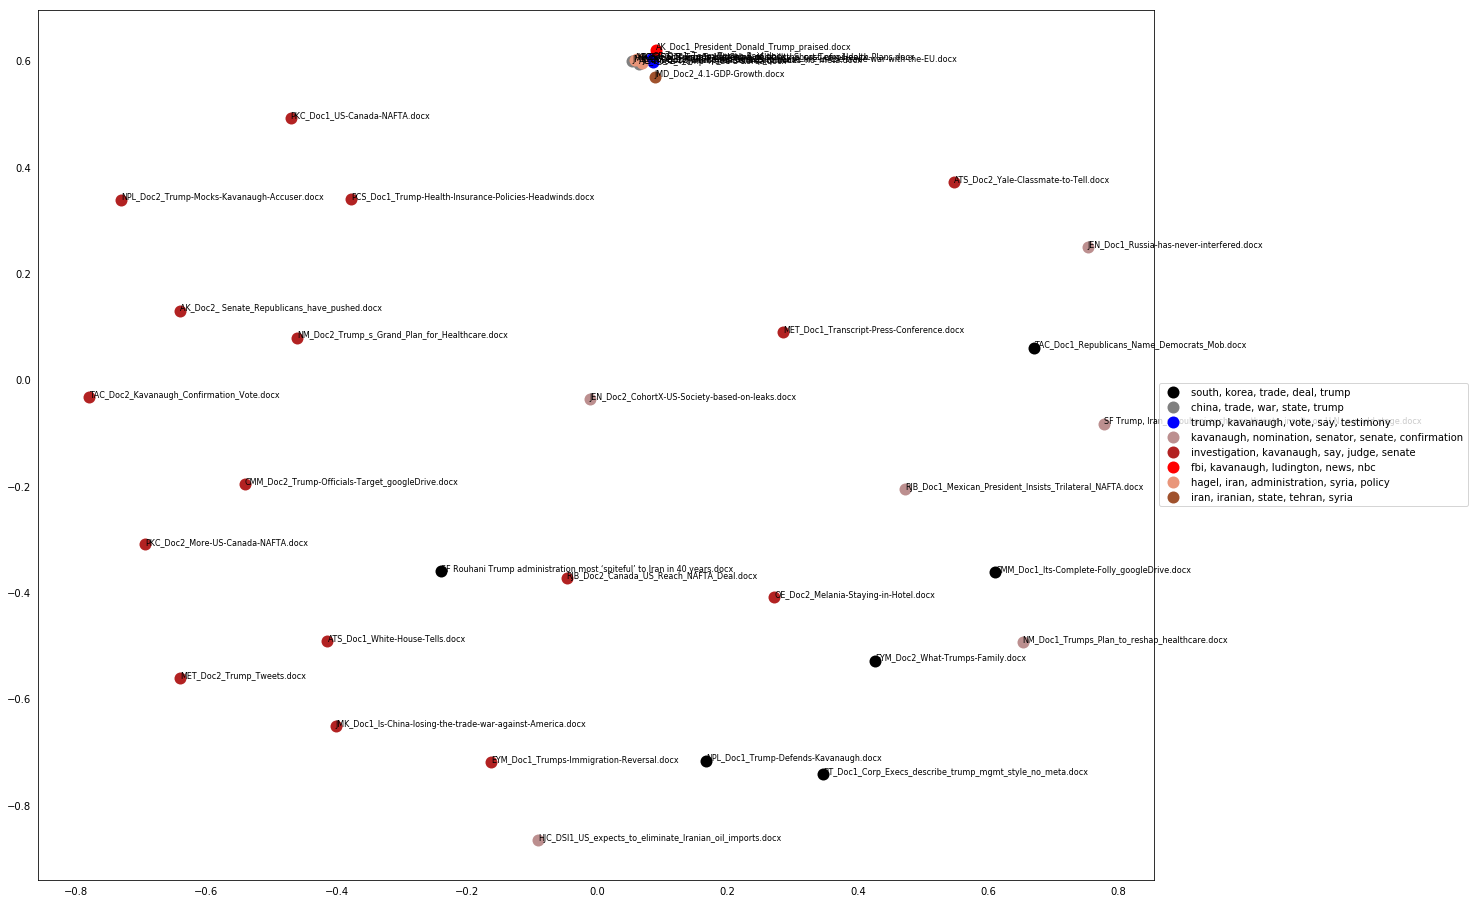

In [6]:
! pip install gensim > /dev/null
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from collections import Counter

cleaned_text=[' '.join([w.text for w in parser(re.sub('\s+', ' ', re.sub('[\n\r\t]', ' ', t)).lower())]) for t in texts]
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(cleaned_text)]
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4, seed=rand_state)

doc2vec_features=[]
for text in tokenized_text:
    doc2vec_features.append(model.infer_vector(text).reshape(1,-1))
doc2vec_features=np.vstack(doc2vec_features)


clusters, order_centroids = get_kmeans_clustering(doc2vec_features)

nb_topics=5
print("top {} most frequent words in {} clusters".format(nb_topics, nb_clusters))
cluster_titles=[]
for i in range(nb_clusters):
  texts_in_cluster=' '.join([' '.join(tokenized_text[k]) for k in clusters if k==i])
  common_words=Counter(texts_in_cluster.split()).most_common()
  words=', '.join([common_words[j][0] for j in range(nb_topics)])
  cluster_titles.append(words)
  print("Cluster {} frequent words: {}".format(i, words))
  
visualize_clusters(doc2vec_features, clusters, cluster_titles)


### Discussions on Doc2Vecc results
All the previous methods use statistical methods based on word-term frequency and probability. Those methods yield pretty good results for small datasets, but they have their disadvantages.  
In this method and all the following below methods we are using dependencies and interactions between words to each other in the document, it means we are using all information existed in the sentence. This feature is the most essential feature of these methods.  
This Doc2Vec method is the first machine learning method to learn the representational vectors from each document based on all words used in the document. However, these machine learning methods usually require a lot of data, and for such short data, it could not represent a very rich representation.  
As we can see from the above figure, almost all documents are in the same area that indicates the encoding space has not a very good standard deviation for representation.

### Training a word2vec from scratch
The following cell demonstrates clustering method using word2vec training and kmeans clustering

top 5 most frequent words in 8 clusters
Cluster 0 frequent words: south, korea, trade, deal, trump
Cluster 1 frequent words: china, trade, war, state, trump
Cluster 2 frequent words: trump, kavanaugh, vote, say, testimony
Cluster 3 frequent words: kavanaugh, nomination, senator, senate, confirmation
Cluster 4 frequent words: investigation, kavanaugh, say, judge, senate
Cluster 5 frequent words: fbi, kavanaugh, ludington, news, nbc
Cluster 6 frequent words: hagel, iran, administration, syria, policy
Cluster 7 frequent words: iran, iranian, state, tehran, syria


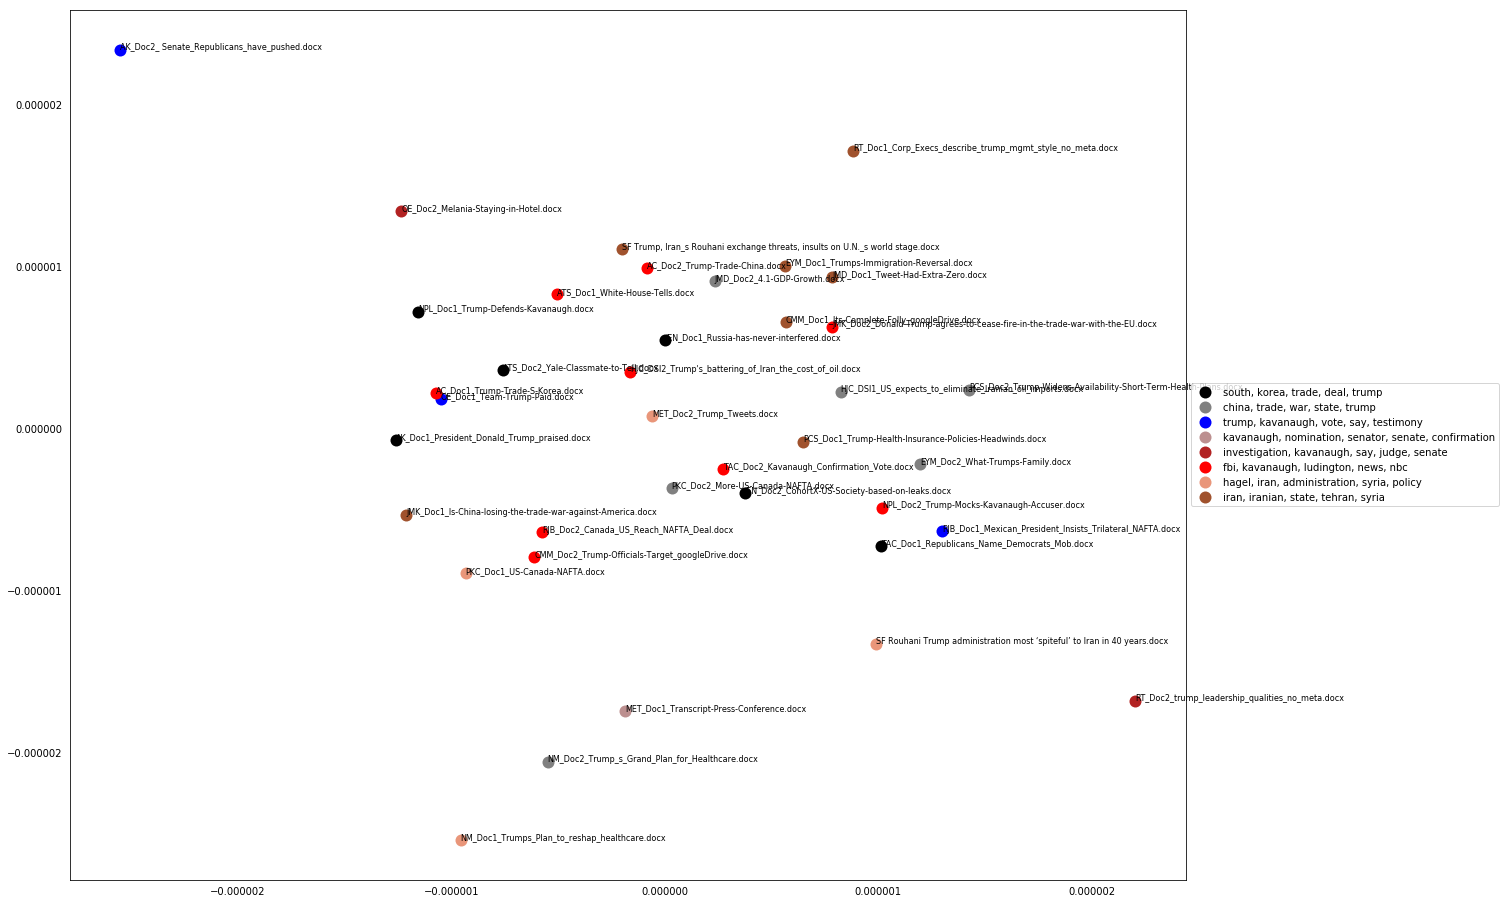

In [7]:
! pip install gensim > /dev/null
from gensim.models import Word2Vec
cleaned_text=[' '.join([w.text for w in parser(re.sub('\s+', ' ', re.sub('[\n\r\t]', ' ', t)).lower())]) for t in texts]
all_words = [w for t in cleaned_text for w in t.split()]
model_w2v = Word2Vec([all_words], size=100, window=5, min_count=1, workers=4)

encoded_sentences = [np.mean(np.vstack([model_w2v.wv[w] for w in t.split()]), axis=0) for t in cleaned_text]
clusters, order_centroids = get_kmeans_clustering(encoded_sentences)

nb_topics=5
print("top {} most frequent words in {} clusters".format(nb_topics, nb_clusters))
cluster_titles=[]
for i in range(nb_clusters):
  texts_in_cluster=' '.join([' '.join(tokenized_text[k]) for k in clusters if k==i])
  common_words=Counter(texts_in_cluster.split()).most_common()
  words=', '.join([common_words[j][0] for j in range(nb_topics)])
  cluster_titles.append(words)
  print("Cluster {} frequent words: {}".format(i, words))
  
visualize_clusters(encoded_sentences, clusters, cluster_titles)
                     

### Discussions on word2vec
As described before, training word2vec behaves similarly to training Doc2Vec.  
The method for such small data can not end to very satisfying results.

### Using pre-trained fast text word vector
In machine learning, one of the best methods to achieve good results is to use the pre-trained network in your small data.  
In the field of NLP, using pre-trained word vectors is the most fundamental example of this scenario.  
Here we are using a pre-trained [fast text](https://arxiv.org/abs/1607.04606) model and evaluate text embedding by getting average word embedding of that text. In the end, as before, we use K-means for clustering.

top 5 most frequent words in 8 clusters
Cluster 0 frequent words: south, korea, trade, deal, trump
Cluster 1 frequent words: china, trade, war, state, trump
Cluster 2 frequent words: trump, kavanaugh, vote, say, testimony
Cluster 3 frequent words: kavanaugh, nomination, senator, senate, confirmation
Cluster 4 frequent words: investigation, kavanaugh, say, judge, senate
Cluster 5 frequent words: fbi, kavanaugh, ludington, news, nbc
Cluster 6 frequent words: hagel, iran, administration, syria, policy
Cluster 7 frequent words: iran, iranian, state, tehran, syria


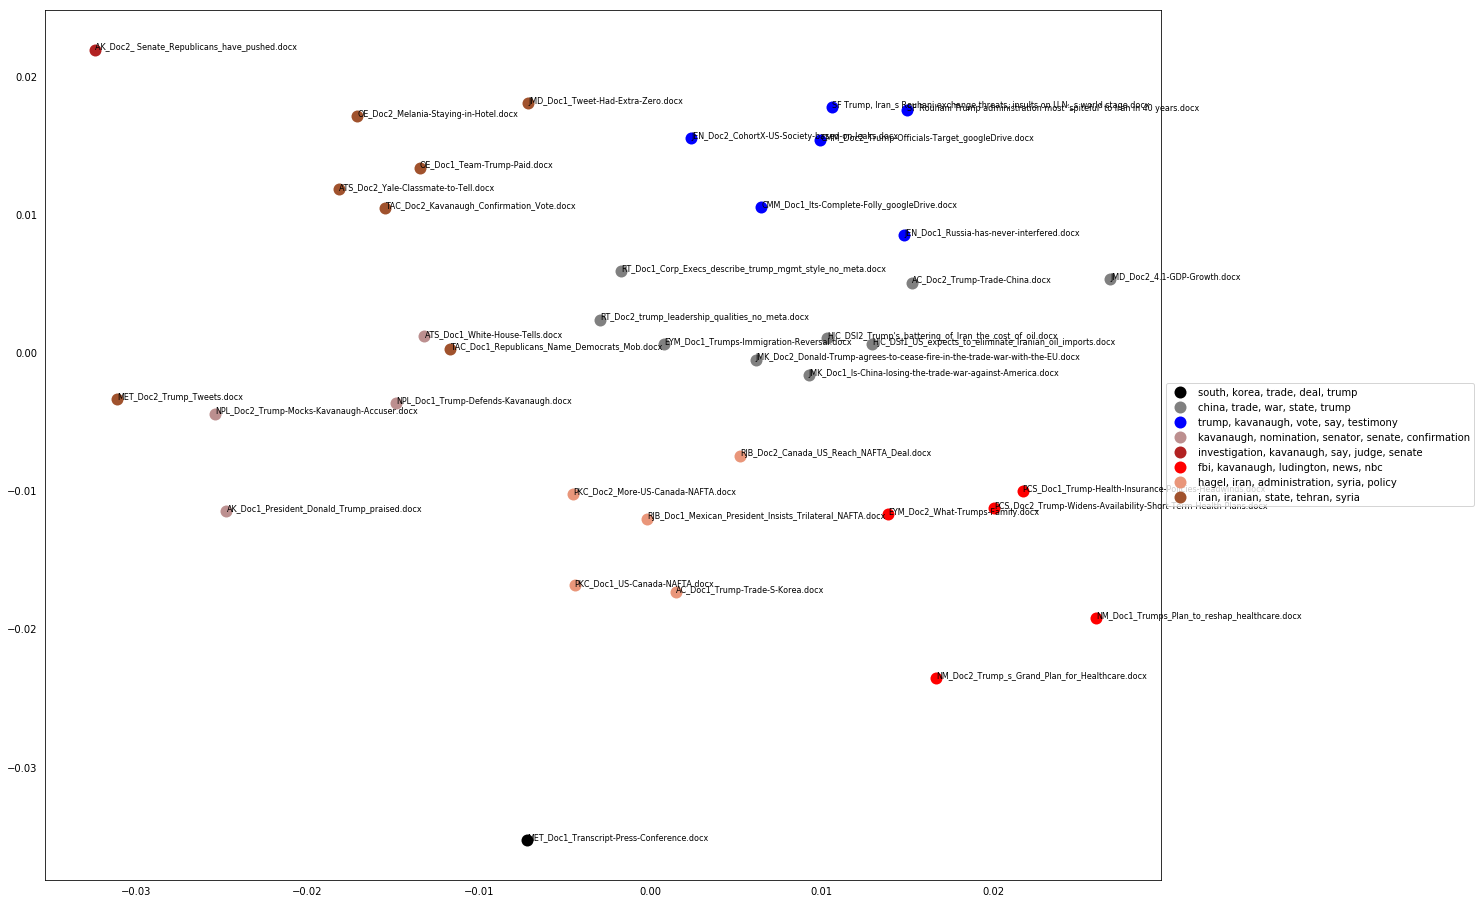

In [8]:

# fasattext
! pip install cython >/dev/null
! pip install cysignals >/dev/null
! pip install pyfasttext >/dev/null
if not os.path.exists("crawl-300d-2M-subword.bin"):
  ! wget https://s3-us-west-1.amazonaws.com/fasttext-vectors/crawl-300d-2M-subword.zip && unzip crawl-300d-2M-subword.zip && unzip crawl-300d-2M-subword.zip
from pyfasttext import FastText

fast_text = FastText()
fast_text.load_model("crawl-300d-2M-subword.bin")
fasttext_features=[fast_text.get_numpy_sentence_vector(sent) for sent in texts]

clusters, order_centroids = get_kmeans_clustering(fasttext_features)

nb_topics=5
print("top {} most frequent words in {} clusters".format(nb_topics, nb_clusters))
cluster_titles=[]
for i in range(nb_clusters):
  texts_in_cluster=' '.join([' '.join(tokenized_text[k]) for k in clusters if k==i])
  common_words=Counter(texts_in_cluster.split()).most_common()
  words=', '.join([common_words[j][0] for j in range(nb_topics)])
  cluster_titles.append(words)
  print("Cluster {} frequent words: {}".format(i, words))
  
visualize_clusters(fasttext_features, clusters, cluster_titles)

### Discussions on fast text pre-training
The above figure shows using pre-trained word vectors how much can help representation and clustering texts.  
You can compare this figure with the previous figure (training word2vec from scratch).  
Basically, when your data is small you have to use some pre-trained network in order to get a satisfying result.

### Using BERT as encoding feature
Our conceptual understanding of how best to represent words and sentences in a way that best captures underlying meanings and relationships is rapidly evolving. One of the most recent methods that are introduced  Bidirectional Encoder Representations from Transformers [BERT](https://arxiv.org/abs/1810.04805).  
In this experiment, we are using BERT to encode sentences into fixed-sized vectors and cluster them with K-means.   

**How to run this**  
First of all, make sure that you have installed the BERT server:  
```bash
pip install pip install bert-serving-server
```
You should run a server to compute BERT features. You can do this in a separate terminal and run the following command:  
```bash 
bert-serving-start -model_dir address_of_cased_L-24_H-1024_A-16 -num_worker 1 -max_seq_len 128  -pooling_layer -1
```
You can download the BERT model from [here](https://storage.googleapis.com/bert_models/2018_10_18/cased_L-24_H-1024_A-16.zip).

top 5 most frequent words in 8 clusters
Cluster 0 frequent words: south, korea, trade, deal, trump
Cluster 1 frequent words: china, trade, war, state, trump
Cluster 2 frequent words: trump, kavanaugh, vote, say, testimony
Cluster 3 frequent words: kavanaugh, nomination, senator, senate, confirmation
Cluster 4 frequent words: investigation, kavanaugh, say, judge, senate
Cluster 5 frequent words: fbi, kavanaugh, ludington, news, nbc
Cluster 6 frequent words: hagel, iran, administration, syria, policy
Cluster 7 frequent words: iran, iranian, state, tehran, syria


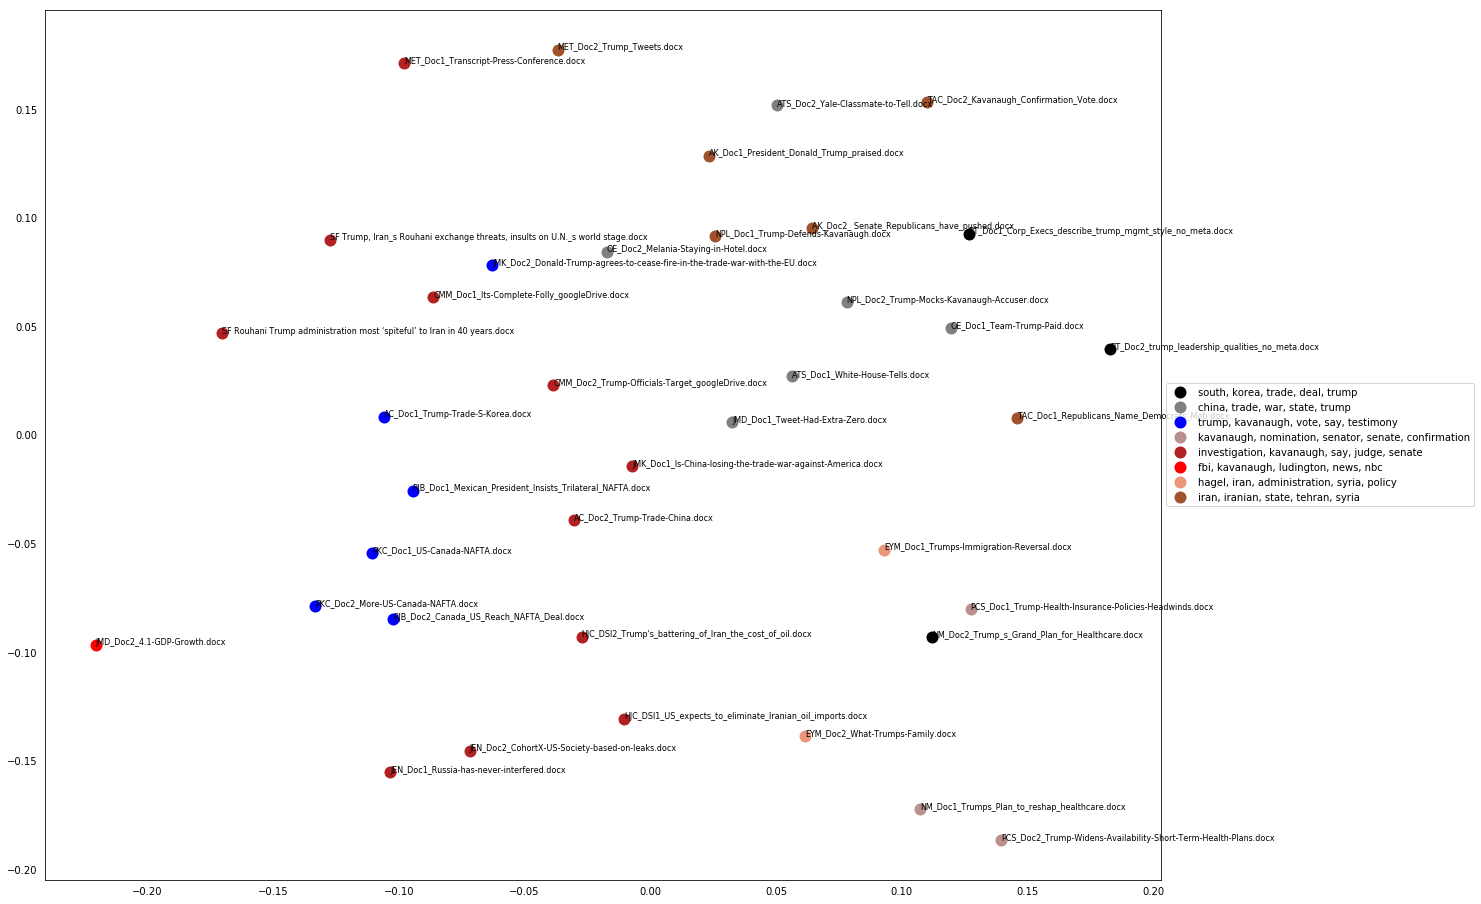

In [9]:
! pip install bert-serving-client > /dev/null  # client
from bert_serving.client import BertClient
bc = BertClient()
encoded_texts = bc.encode(texts)
clusters, order_centroids = get_kmeans_clustering(encoded_texts)

nb_topics=5
print("top {} most frequent words in {} clusters".format(nb_topics, nb_clusters))
cluster_titles=[]
for i in range(nb_clusters):
  texts_in_cluster=' '.join([' '.join(tokenized_text[k]) for k in clusters if k==i])
  common_words=Counter(texts_in_cluster.split()).most_common()
  words=', '.join([common_words[j][0] for j in range(nb_topics)])
  cluster_titles.append(words)
  print("Cluster {} frequent words: {}".format(i, words))
  
visualize_clusters(encoded_texts, clusters, cluster_titles)

### Discussions on BERT encoding
All the previous machine learning based methods have used an elementary model for getting interaction between words in a sentence. However, the most characteristic feature of BERT is its ability to learn complex interaction between words each sentence using [Transformer](https://jalammar.github.io/illustrated-transformer/).  
This method is our final and best method for getting encoded information on each sentence that is [introduced](https://jalammar.github.io/illustrated-bert/) as the state-of-the-art method for general tasks of NLP.

# Final discussions and conclusion
In this notebook, we explored six methods for getting encoding information of texts for the provided small and straightforward dataset.  
We discussed two basic methods which namely are:
1. Traditional statistical methods like tf-idf and LDA
2. Using machine learning and recent NLP methods.  

Although the simple and statistical methods like tf-idf and LDA are great for these small and non-complex datasets, however, they would fail to model more substantial and complex datasets. Therefore, in the NLP community, there have been a lot of works and papers that try to tackle this task more efficiently. You can see a good overview of these efforts in [this](https://jalammar.github.io/illustrated-bert/) blog post.  

## Statistical methods: 
* Advantages
    1. Its simplicity: they are simple to use
    2. Interpretability: it is easy to explain based on words existed to each cluster
* Disadvantages
   1. Requires a complex and careful pre-processing (word stemming, ...)
   2. It does not encode interaction between words of each sentence. It just computes some statistical measurements of words in each document.
  
## Machine learning methods
* Advantages
   1. This is a very hot topic in the community, and there are a lot of recent works in which try to address this problem
   2. It can encode complex interaction between words.
   3. It does not require a very complex pre-processing work
   
* Disadvantages
   1. The interpretability of machine learning methods is sometimes hard.
   2. Some machine learning method like BERT could be very complex and requires some specific hardware (GPU/TPU) to use them 